# Input Data Analytics for Expected Proceeds

This notebook analyzes the input data for the expected proceeds prediction model to understand:
1. Finished cohorts (over 8 days old for d8 and over 100 days for d100)
2. User type distribution and behavior
3. Proceeds distribution across marketing channels and campaigns
4. Product-level proceeds ratios between d8 and d100
5. Purchase timing distribution for 'other' user types

In [1]:
# Install required packages
!pip3 install numpy==1.23.5
!pip3 install pandas==1.5.3
!pip3 install pyarrow==10.0.1
!pip3 install "snowflake-connector-python[pandas]"
!pip3 install snowflake-snowpark-python
!pip3 install matplotlib==3.7.1
!pip3 install seaborn==0.12.2
!pip3 install plotly==5.14.1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set plotting styles
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Import custom modules for user type splitting
from data_utils import split_data_by_user_type

## Connect to Snowflake and Load Data

In [3]:
# Import Snowflake connection config
import config

# Snowflake connection
from snowflake.snowpark import Session

def get_snowflake_session():
    """Create and return a Snowflake session"""
    connection_parameters = {
        "account": config.SNOWFLAKE_ACCOUNT,
        "user": config.SNOWFLAKE_USER,
        "role": config.SNOWFLAKE_ROLE,
        "warehouse": config.SNOWFLAKE_WAREHOUSE,
        "database": config.SNOWFLAKE_DATABASE,
        "schema": config.SNOWFLAKE_SCHEMA,
        "authenticator": config.SNOWFLAKE_AUTHENTICATOR
    }
    
    session = Session.builder.configs(connection_parameters).create()
    print(f"Connected to Snowflake as {config.SNOWFLAKE_USER}")
    return session

# Create a Snowflake session
session = get_snowflake_session()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://blinkist-useast_1_virginia.snowflakecomputing.com/console/login?login_name=meri-kris.jaama%40go1.com&browser_mode_redirect_port=61150&proof_key=WD4Ak8BmcmIwiTZYXeQiWgYwBoMx42RkKUMJdF3Z2Rw%3D to authenticate...
Connected to Snowflake as meri-kris.jaama@go1.com


In [4]:
# Load input data from Snowflake
query = """
SELECT *
FROM BLINKIST_DEV.DBT_MJAAMA.EXP_PROCEEDS_INPUT
WHERE REPORT_DATE >= DATEADD(day, -365, CURRENT_DATE())
"""

input_df = session.sql(query).to_pandas()

# Convert column names to lowercase for consistency
input_df.columns = [col.lower() for col in input_df.columns]

print(f"Loaded {len(input_df):,} input records")

Loaded 3,084,823 input records


## 1. Filter for Finished Cohorts

We'll filter the data to include only finished cohorts:
- For d8 analysis: cohorts that are at least 8 days old
- For d100 analysis: cohorts that are at least 100 days old

In [5]:
# Get current date
current_date = datetime.now().date()

# Convert report_date to datetime
input_df['report_date'] = pd.to_datetime(input_df['report_date']).dt.date

# Filter for finished cohorts
d8_cutoff_date = current_date - timedelta(days=8)
d100_cutoff_date = current_date - timedelta(days=100)

# Create filtered datasets
d8_cohorts_df = input_df[input_df['report_date'] <= d8_cutoff_date].copy()
d100_cohorts_df = input_df[input_df['report_date'] <= d100_cutoff_date].copy()

print(f"D8 Cohorts: {len(d8_cohorts_df):,} records")
print(f"D100 Cohorts: {len(d100_cohorts_df):,} records")

D8 Cohorts: 3,050,050 records
D100 Cohorts: 2,114,752 records


## 2. Get User Type for Each Entry

In [7]:
# Unpack the returned DataFrames
trial_users_df, day0_payers_df, other_users_df = split_data_by_user_type(d8_cohorts_df)

# Add a 'user_type' column to each DataFrame
trial_users_df['user_type'] = 'trial'
day0_payers_df['user_type'] = 'day0_payers'
other_users_df['user_type'] = 'other'

# Concatenate the DataFrames to get a complete view
d8_with_user_type = pd.concat([trial_users_df, day0_payers_df, other_users_df])

# Display user type distribution
user_type_counts = d8_with_user_type['user_type'].value_counts()
print("User Type Distribution (D8 Cohorts):")
display(user_type_counts)

User Type Distribution (D8 Cohorts):


other          2773203
trial           162224
day0_payers     113248
Name: user_type, dtype: int64

In [9]:
# Unpack the returned DataFrames for d100 cohorts
trial_users_df, day0_payers_df, other_users_df = split_data_by_user_type(d100_cohorts_df)

# Add a 'user_type' column to each DataFrame
trial_users_df['user_type'] = 'trial'
day0_payers_df['user_type'] = 'day0_payers'
other_users_df['user_type'] = 'other'

# Concatenate the DataFrames to get a complete view
d100_with_user_type = pd.concat([trial_users_df, day0_payers_df, other_users_df])

## 3. Aggregate Proceeds by Marketing Dimensions

We'll aggregate proceeds on the level of marketing dimensions and find the proportion of proceeds driven by each group.

In [17]:
import pandas as pd

# Assuming `input_df` is your DataFrame containing the data
# Ensure 'eur_proceeds_d100' is the column representing the proceeds

# Group by channel_group and user_type
proceeds_by_group = d100_with_user_type.groupby(['channel_group', 'user_type']).agg({
    'eur_proceeds_d100': 'sum'
}).reset_index()

# Calculate total proceeds for each channel_group
total_proceeds_by_channel = proceeds_by_group.groupby('channel_group')['eur_proceeds_d100'].transform('sum')

# Calculate the percentage share within each channel_group
proceeds_by_group['proceeds_share'] = (proceeds_by_group['eur_proceeds_d100'] / total_proceeds_by_channel) * 100

# Display the results
print("Proceeds Share by Channel Group and User Type:")
display(proceeds_by_group)

Proceeds Share by Channel Group and User Type:


,channel_group,user_type,eur_proceeds_d100,proceeds_share
0,affiliate_and_partnerships,day0_payers,1.895267e+05,76.405564
1,affiliate_and_partnerships,other,1.627387e+04,6.560625
2,affiliate_and_partnerships,trial,4.225298e+04,17.033811
3,brand_search,day0_payers,5.737861e+05,58.383441
4,brand_search,other,1.129076e+05,11.488489
5,brand_search,trial,2.960954e+05,30.128071
6,display_and_programmatic,day0_payers,7.423758e+05,41.306387
7,display_and_programmatic,other,3.325433e+05,18.502976
8,display_and_programmatic,trial,7.223231e+05,40.190638
9,generic_search,day0_payers,1.209567e+05,44.282718


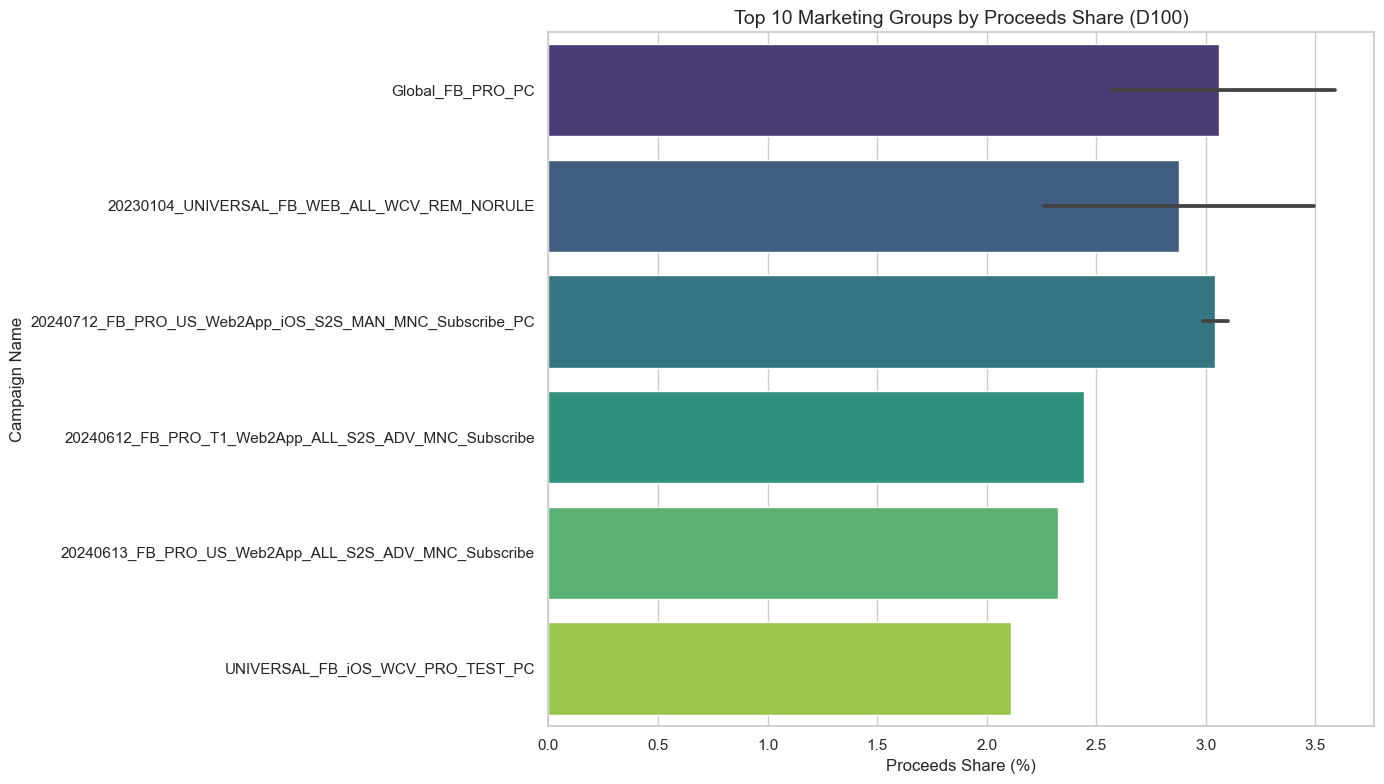

In [10]:
# Define marketing dimensions
marketing_dimensions = [
    "channel_group", "marketing_network_id", "account_id", 
    "campaign_name", "campaign_id", "adgroup_name", "adgroup_id", "target_market"
]

# Check if all dimensions are present
if all(dim in d100_with_user_type.columns for dim in marketing_dimensions):
    # Aggregate proceeds by marketing dimensions
    proceeds_by_marketing = d100_with_user_type.groupby(marketing_dimensions).agg({
        'eur_proceeds_d100': 'sum'
    }).reset_index()
    
    # Calculate proportion of total proceeds
    total_proceeds = proceeds_by_marketing['eur_proceeds_d100'].sum()
    proceeds_by_marketing['proceeds_share'] = proceeds_by_marketing['eur_proceeds_d100'] / total_proceeds * 100
    
    # Sort by proceeds
    proceeds_by_marketing = proceeds_by_marketing.sort_values('eur_proceeds_d100', ascending=False)
    
    # Plot top 10 marketing groups by proceeds
    top_marketing_groups = proceeds_by_marketing.head(10)
    plt.figure(figsize=(14, 8))
    sns.barplot(x='proceeds_share', y='campaign_name', data=top_marketing_groups, palette='viridis')
    plt.title('Top 10 Marketing Groups by Proceeds Share (D100)', fontsize=14)
    plt.xlabel('Proceeds Share (%)', fontsize=12)
    plt.ylabel('Campaign Name', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Not all marketing dimensions are present in the data.")

## 4. Analyze Product-Level Proceeds Ratios

We'll analyze the ratio of D100 to D8 proceeds for each product to understand the long-term value multiplier.

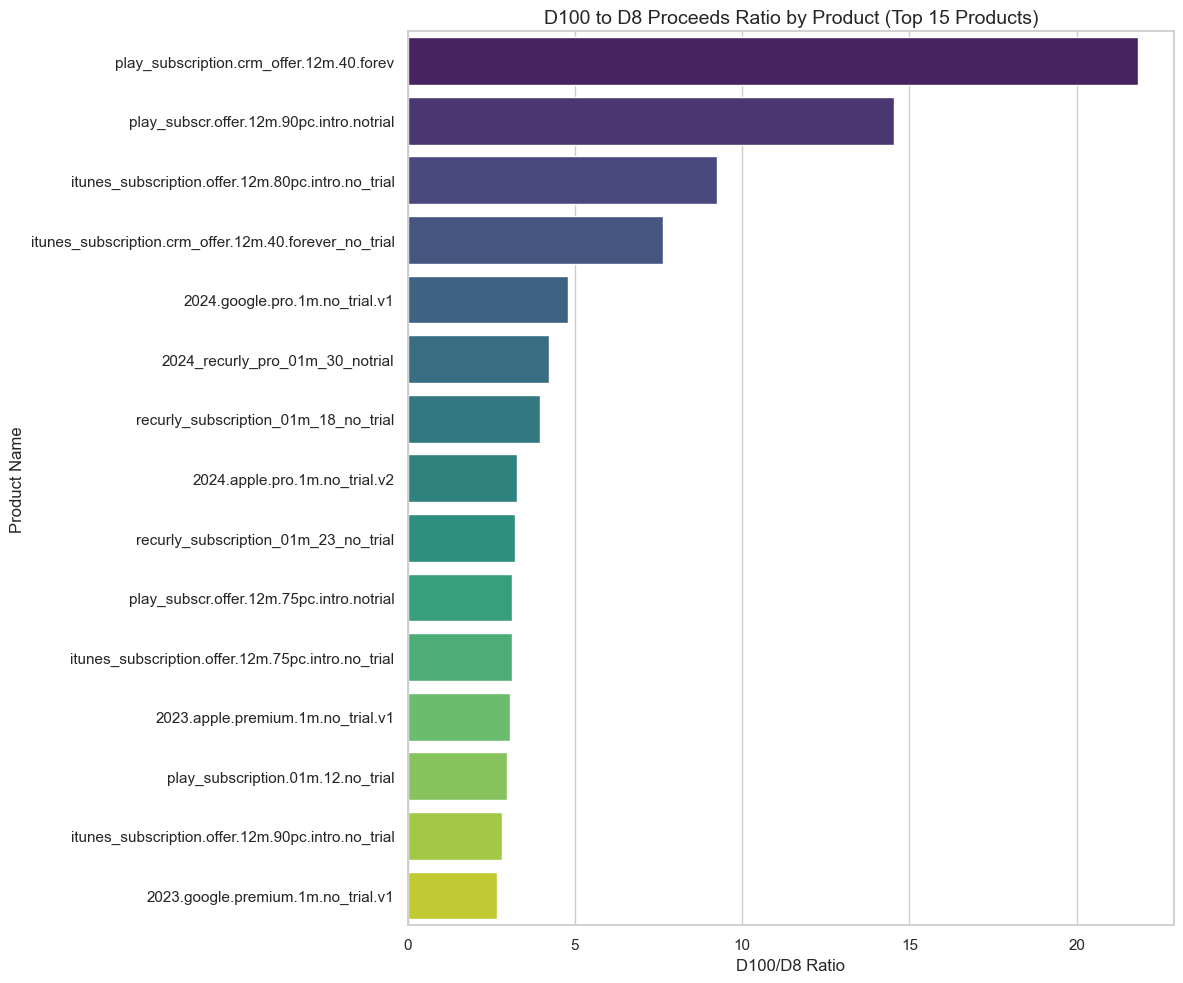

In [11]:
# Aggregate by product
product_agg = d100_with_user_type.groupby('product_name').agg({
    'eur_proceeds_d8': 'sum',
    'eur_proceeds_d100': 'sum',
    'user_id': 'count'
}).reset_index()

# Calculate ratio
product_agg['d100_to_d8_ratio'] = product_agg['eur_proceeds_d100'] / product_agg['eur_proceeds_d8'].replace(0, np.nan)
product_agg = product_agg.sort_values('eur_proceeds_d100', ascending=False)

# Filter for products with significant data
significant_products = product_agg[product_agg['user_id'] >= 10].copy()

# Create a horizontal bar chart for the D100/D8 ratio
plt.figure(figsize=(12, 10))
sns.barplot(x='d100_to_d8_ratio', y='product_name', 
            data=significant_products.sort_values('d100_to_d8_ratio', ascending=False).head(15),
            palette='viridis')
plt.title('D100 to D8 Proceeds Ratio by Product (Top 15 Products)', fontsize=14)
plt.xlabel('D100/D8 Ratio', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.tight_layout()
plt.show()

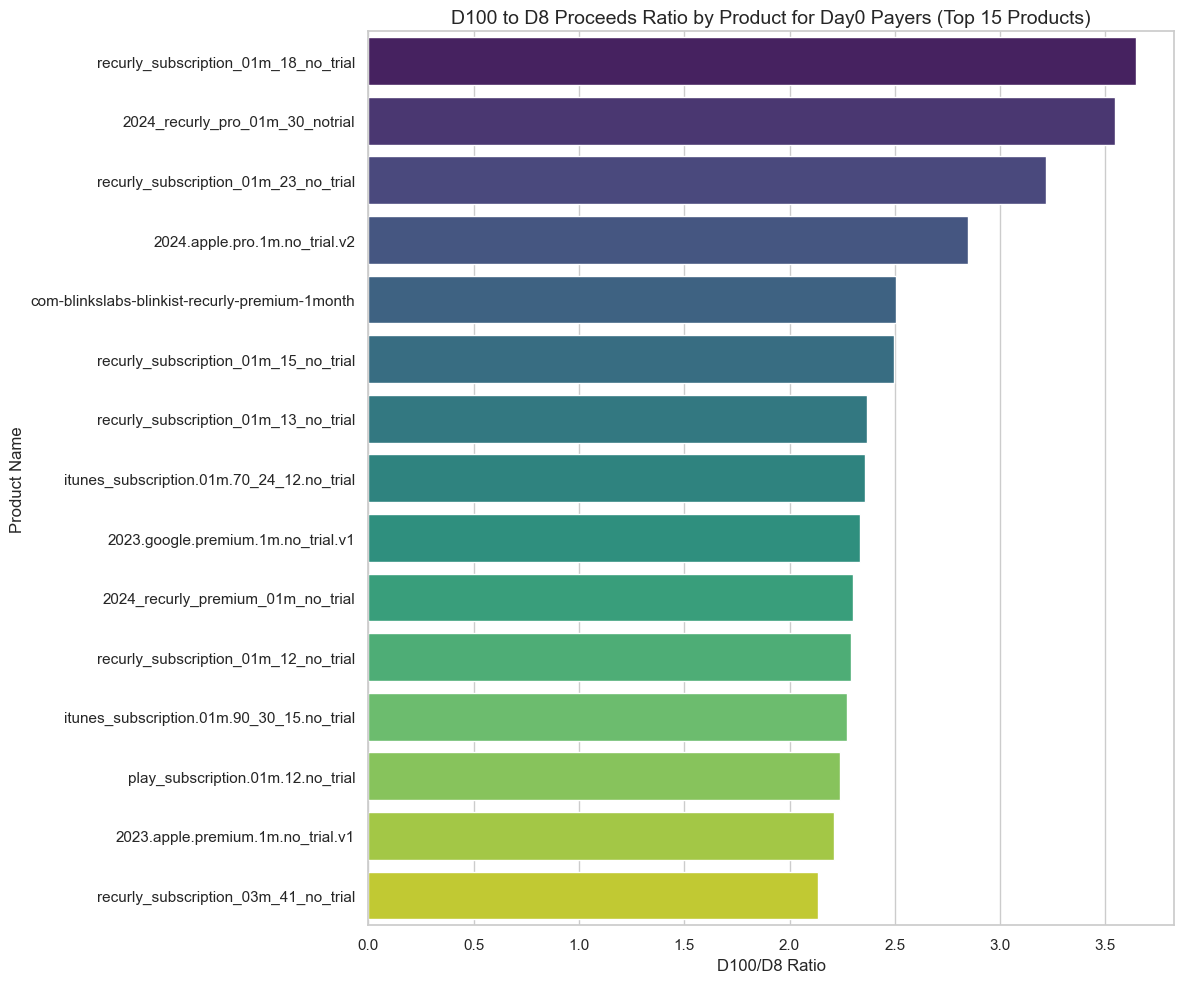

In [14]:
## 4. Analyze Product-Level Proceeds Ratios for Day0 Payers

# Filter the d100_with_user_type DataFrame for day0_payers
day0_payers_df = d100_with_user_type[d100_with_user_type['user_type'] == 'day0_payers']

# Aggregate by product
product_agg = day0_payers_df.groupby('product_name').agg({
    'eur_proceeds_d8': 'sum',
    'eur_proceeds_d100': 'sum',
    'user_id': 'count'
}).reset_index()

# Calculate ratio
product_agg['d100_to_d8_ratio'] = product_agg['eur_proceeds_d100'] / product_agg['eur_proceeds_d8'].replace(0, np.nan)
product_agg = product_agg.sort_values('eur_proceeds_d100', ascending=False)

# Filter for products with significant data
significant_products = product_agg[product_agg['user_id'] >= 10].copy()

# Create a horizontal bar chart for the D100/D8 ratio
plt.figure(figsize=(12, 10))
sns.barplot(x='d100_to_d8_ratio', y='product_name', 
            data=significant_products.sort_values('d100_to_d8_ratio', ascending=False).head(15),
            palette='viridis')
plt.title('D100 to D8 Proceeds Ratio by Product for Day0 Payers (Top 15 Products)', fontsize=14)
plt.xlabel('D100/D8 Ratio', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
display(product_agg)

,product_name,eur_proceeds_d8,eur_proceeds_d100,user_id,d100_to_d8_ratio
15,2024.apple.pro.12m.no_trial.v2,750654.000239,752294.554599,10622,1.002186
84,itunes_subscription.12m.80_26_13.trial_7,637647.682811,661690.860350,35976,1.037706
0,2023.apple.premium.12m.no_trial.v1,401693.029396,403460.902079,7952,1.004401
46,2024_recurly_pro_12m_notrial,340345.501643,353955.091623,8920,1.039988
58,com-blinkslabs-blinkist-recurly-premium-1year-...,326737.456104,343801.577399,13336,1.052226
...,...,...,...,...,...
49,2025.google.pro.1m.intro_offer_25.v1,0.000000,0.000000,1,NaN
48,2025.apple.pro.1m.intro_offer_25.v1,0.000000,0.000000,3,NaN
57,com-blinkslabs-blinkist-recurly-premium-1year,0.000000,0.000000,1,NaN
119,play_subscription.crm_offer.12m.20.forev,0.000000,0.000000,1,NaN


## 5. Analyze Purchase Timing for 'Other' Users

For users in the 'other' category who eventually made a purchase (proceeds_d100 > 0), we'll analyze the distribution of days to purchase.

Days to Purchase Statistics:


count    31001.000000
mean         4.896132
std        155.695949
min      -3182.000000
25%          3.000000
50%         10.000000
75%         27.000000
max        100.000000
Name: days_to_purchase, dtype: float64

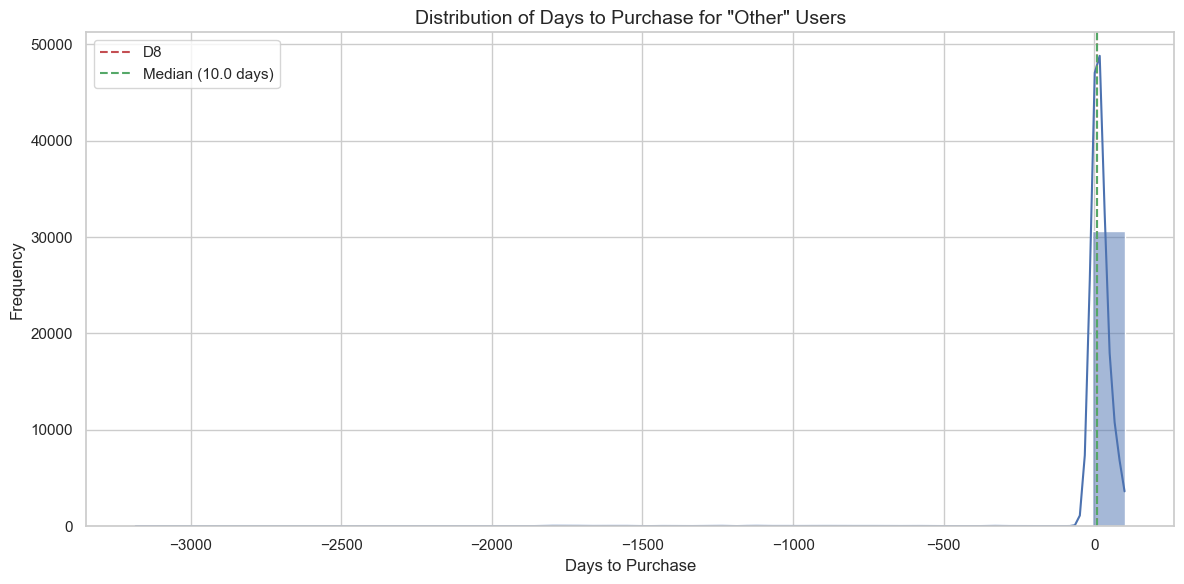

In [12]:
# Filter for 'other' users with D100 proceeds > 0
other_purchasers = d100_with_user_type[(d100_with_user_type['user_type'] == 'other') & (d100_with_user_type['eur_proceeds_d100'] > 0)].copy()

# Check if we have days_to_purchase column
if 'days_to_purchase' in other_purchasers.columns:
    # Use existing column
    days_to_purchase = other_purchasers['days_to_purchase']
else:
    # Try to calculate it from available data
    if 'first_purchase_date' in other_purchasers.columns and 'report_date' in other_purchasers.columns:
        other_purchasers['first_purchase_date'] = pd.to_datetime(other_purchasers['first_purchase_date'])
        other_purchasers['report_date'] = pd.to_datetime(other_purchasers['report_date'])
        other_purchasers['days_to_purchase'] = (other_purchasers['first_purchase_date'] - other_purchasers['report_date']).dt.days
    else:
        # If we can't calculate it, create a simulated distribution for demonstration
        print("Warning: Could not calculate days_to_purchase from available data. Using simulated data for demonstration.")
        np.random.seed(42)
        other_purchasers['days_to_purchase'] = np.random.exponential(scale=15, size=len(other_purchasers)).astype(int) + 1
        other_purchasers['days_to_purchase'] = other_purchasers['days_to_purchase'].clip(upper=100)

# Analyze the distribution
days_stats = other_purchasers['days_to_purchase'].describe()
print("Days to Purchase Statistics:")
display(days_stats)

# Create a histogram
plt.figure(figsize=(12, 6))
sns.histplot(other_purchasers['days_to_purchase'], bins=30, kde=True)
plt.axvline(x=8, color='r', linestyle='--', label='D8')
plt.axvline(x=other_purchasers['days_to_purchase'].median(), color='g', linestyle='--', 
            label=f'Median ({other_purchasers["days_to_purchase"].median():.1f} days)')
plt.title('Distribution of Days to Purchase for "Other" Users', fontsize=14)
plt.xlabel('Days to Purchase', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()